<a href="https://colab.research.google.com/github/Akash-9009/CODE-CREW-2025-26/blob/main/FED%2BIntensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Install required libraries (Colab-friendly). Run this cell first in Colab.
!pip install -q tensorflow keras opencv-python-headless scikit-learn seaborn matplotlib scikit-plot pandas

# (If you run locally and already have these packages, you can skip this cell.)

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [7]:
# ============================================
# Load FER2013 CSV from a ZIP file
# ============================================

import zipfile
import os
import pandas as pd

# Path to the uploaded ZIP file
zip_path = 'fer2013.zip'   # <-- make sure the zip file name matches exactly

# Extract ZIP if not already extracted
if not os.path.exists('fer2013.csv'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')   # extracts in the current directory
    print("✅ Extracted successfully!")

# Check if CSV exists after extraction
csv_path = 'fer2013.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        "fer2013.csv not found inside the zip file.\n"
        "Please confirm the zip actually contains a file named 'fer2013.csv'."
    )

# Read the dataset
print(f"📖 Reading {csv_path} ...")
df = pd.read_csv(csv_path)
print('✅ Loaded successfully!')
print('Columns:', df.columns.tolist())
df.head()


✅ Extracted successfully!
📖 Reading fer2013.csv ...
✅ Loaded successfully!
Columns: ['emotion', 'pixels', 'Usage']


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
# Preprocess images: convert 'pixels' column strings to 48x48 arrays and normalize to [0,1]

# Expecting FER2013 shape 48x48
IMAGE_SIZE = 48

def pixels_to_array(pixels_str):
    # pixels_str is a space-separated string of 2304 integers
    arr = np.fromstring(pixels_str, dtype=int, sep=' ')
    if arr.size != IMAGE_SIZE*IMAGE_SIZE:
        raise ValueError(f'Unexpected number of pixels: {arr.size}')
    arr = arr.reshape((IMAGE_SIZE, IMAGE_SIZE))
    return arr

# Convert
images = np.stack(df['pixels'].apply(pixels_to_array).values)
images = images.astype('float32')

# INTENSITY NORMALIZATION TO [0,1]
images /= 255.0

# Expand channel dimension for Keras (grayscale)
images = np.expand_dims(images, -1)

labels = df['emotion'].values
usage = df['Usage'].values

print('images shape:', images.shape)
print('labels shape:', labels.shape)
print('Usage distribution:')
print(pd.Series(usage).value_counts())

images shape: (35887, 48, 48, 1)
labels shape: (35887,)
Usage distribution:
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


In [9]:
# Split according to Usage column if present ('Training','PublicTest','PrivateTest')

if 'Usage' in df.columns:
    train_idx = df['Usage'] == 'Training'
    val_idx = df['Usage'] == 'PublicTest'
    test_idx = df['Usage'] == 'PrivateTest'

    X_train = images[train_idx.values]
    y_train = labels[train_idx.values]
    X_val = images[val_idx.values]
    y_val = labels[val_idx.values]
    X_test = images[test_idx.values]
    y_test = labels[test_idx.values]
else:
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42, stratify=labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (28709, 48, 48, 1) Val: (3589, 48, 48, 1) Test: (3589, 48, 48, 1)


In [10]:
# One-hot encode labels
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(labels))

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print('num classes =', num_classes)

num classes = 7


In [11]:
# Data augmentation
batch_size = 64
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train_cat, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val_cat, batch_size=batch_size)

steps_per_epoch = len(X_train) // batch_size
validation_steps = max(1, len(X_val) // batch_size)

print('steps_per_epoch =', steps_per_epoch, 'validation_steps =', validation_steps)

steps_per_epoch = 448 validation_steps = 56


In [12]:
# Build the CNN model

def build_model(input_shape=(48,48,1), num_classes=7):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inp, outputs=out)
    return model

model = build_model(input_shape=(48,48,1), num_classes=num_classes)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,79

 Total params: 2,919,111 (11.14 MB)

 Trainable params: 2,917,319 (11.13 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_fer_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Training
epochs = 60
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Save the final model
model.save('fer_cnn_intensity_normalized.h5')
print('Model saved to fer_cnn_intensity_normalized.h5')

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2294 - loss: 2.3001
Epoch 1: val_accuracy improved from -inf to 0.27483, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.2295 - loss: 2.2990 - val_accuracy: 0.2748 - val_loss: 1.7819 - learning_rate: 0.0010
Epoch 2/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.3750 - loss: 1.6893

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.27483 to 0.27902, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3750 - loss: 1.6893 - val_accuracy: 0.2790 - val_loss: 1.7719 - learning_rate: 0.0010
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3701 - loss: 1.6250
Epoch 3: val_accuracy improved from 0.27902 to 0.47377, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3702 - loss: 1.6248 - val_accuracy: 0.4738 - val_loss: 1.3700 - learning_rate: 0.0010
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4062 - loss: 1.4049
Epoch 4: val_accuracy did not improve from 0.47377
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4062 - loss: 1.4049 - val_accuracy: 0.4651 - val_loss: 1.4007 - learning_rate: 0.0010
Epoch 5/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4594 - loss: 1.3976
Epoch 5: val_accuracy improved from 0.47377 to 0.49470, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4595 - loss: 1.3975 - val_accuracy: 0.4947 - val_loss: 1.3164 - learning_rate: 0.0010
Epoch 6/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4688 - loss: 1.4065
Epoch 6: val_accuracy improved from 0.49470 to 0.50223, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4688 - loss: 1.4065 - val_accuracy: 0.5022 - val_loss: 1.3063 - learning_rate: 0.0010
Epoch 7/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4987 - loss: 1.3013
Epoch 7: val_accuracy improved from 0.50223 to 0.55859, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.4987 - loss: 1.3013 - val_accuracy: 0.5586 - val_loss: 1.1882 - learning_rate: 0.0010
Epoch 8/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5000 - loss: 1.2925
Epoch 8: val_accuracy did not improve from 0.55859
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.2925 - val_accuracy: 0.5539 - val_loss: 1.1991 - learning_rate: 0.0010
Epoch 9/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5240 - loss: 1.2523
Epoch 9: val_accuracy did not improve from 0.55859
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5240 - loss: 1.2523 - val_accuracy: 0.5377 - val_loss: 1.2278 - learning_rate: 0.0010
Epoch 10/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4688 - loss: 1.4659
Epoch 10: val_accuracy did not improve from 0.55859
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 1.4659 - val_accuracy: 0.5276 - val_loss: 1.2587 - learning_rate: 0.0010
Epoch 11/60
44

448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5650 - loss: 1.1471 - val_accuracy: 0.5781 - val_loss: 1.1069 - learning_rate: 5.0000e-04
Epoch 14/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5469 - loss: 1.2480
Epoch 14: val_accuracy improved from 0.57812 to 0.58315, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5469 - loss: 1.2480 - val_accuracy: 0.5831 - val_loss: 1.1040 - learning_rate: 5.0000e-04
Epoch 15/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5735 - loss: 1.1228
Epoch 15: val_accuracy improved from 0.58315 to 0.60017, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5736 - loss: 1.1228 - val_accuracy: 0.6002 - val_loss: 1.0622 - learning_rate: 5.0000e-04
Epoch 16/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6406 - loss: 1.0503
Epoch 16: val_accuracy improved from 0.60017 to 0.60156, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 1.0503 - val_accuracy: 0.6016 - val_loss: 1.0576 - learning_rate: 5.0000e-04
Epoch 17/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5833 - loss: 1.0964
Epoch 17: val_accuracy did not improve from 0.60156
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.5833 - loss: 1.0964 - val_accuracy: 0.5848 - val_loss: 1.0883 - learning_rate: 5.0000e-04
Epoch 18/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5156 - loss: 1.1856
Epoch 18: val_accuracy did not improve from 0.60156
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5156 - loss: 1.1856 - val_accuracy: 0.5868 - val_loss: 1.0884 - learning_rate: 5.0000e-04
Epoch 19/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5954 - loss: 1.0736
Epoch 19: val_accuracy did not improve from 0.60156
448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5954 - loss: 1.0736 - val_accuracy: 0.5834 - val_loss: 1.1027 - learning_rate: 5.0000

448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6054 - loss: 1.0552 - val_accuracy: 0.6027 - val_loss: 1.0717 - learning_rate: 5.0000e-04
Epoch 22/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.6250 - loss: 0.9346
Epoch 22: val_accuracy did not improve from 0.60268
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 0.9346 - val_accuracy: 0.6021 - val_loss: 1.0722 - learning_rate: 2.5000e-04
Epoch 23/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6108 - loss: 1.0292
Epoch 23: val_accuracy improved from 0.60268 to 0.61970, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.6108 - loss: 1.0292 - val_accuracy: 0.6197 - val_loss: 1.0071 - learning_rate: 2.5000e-04
Epoch 24/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5469 - loss: 1.0109
Epoch 24: val_accuracy did not improve from 0.61970
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5469 - loss: 1.0109 - val_accuracy: 0.6194 - val_loss: 1.0067 - learning_rate: 2.5000e-04
Epoch 25/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6231 - loss: 1.0104
Epoch 25: val_accuracy improved from 0.61970 to 0.61998, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6231 - loss: 1.0104 - val_accuracy: 0.6200 - val_loss: 0.9998 - learning_rate: 2.5000e-04
Epoch 26/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5938 - loss: 1.1370
Epoch 26: val_accuracy improved from 0.61998 to 0.62081, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 1.1370 - val_accuracy: 0.6208 - val_loss: 0.9976 - learning_rate: 2.5000e-04
Epoch 27/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6270 - loss: 0.9984
Epoch 27: val_accuracy improved from 0.62081 to 0.62863, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.6270 - loss: 0.9984 - val_accuracy: 0.6286 - val_loss: 0.9779 - learning_rate: 2.5000e-04
Epoch 28/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.6250 - loss: 0.9546
Epoch 28: val_accuracy improved from 0.62863 to 0.63030, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 0.9546 - val_accuracy: 0.6303 - val_loss: 0.9772 - learning_rate: 2.5000e-04
Epoch 29/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6296 - loss: 0.9942
Epoch 29: val_accuracy did not improve from 0.63030
448/448 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.6296 - loss: 0.9942 - val_accuracy: 0.6278 - val_loss: 1.0088 - learning_rate: 2.5000e-04
Epoch 30/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5625 - loss: 1.1293
Epoch 30: val_accuracy did not improve from 0.63030
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.1293 - val_accuracy: 0.6297 - val_loss: 1.0062 - learning_rate: 2.5000e-04
Epoch 31/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6293 - loss: 0.9863
Epoch 31: val_accuracy did not improve from 0.63030
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6293 - loss: 0.9863 - val_accuracy: 0.6258 - val_loss: 0.9860 - learning_rate: 2.5000

448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6360 - loss: 0.9687 - val_accuracy: 0.6378 - val_loss: 0.9659 - learning_rate: 1.2500e-04
Epoch 38/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6875 - loss: 0.9330
Epoch 38: val_accuracy did not improve from 0.63783
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.9330 - val_accuracy: 0.6359 - val_loss: 0.9667 - learning_rate: 1.2500e-04
Epoch 39/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6435 - loss: 0.9497
Epoch 39: val_accuracy did not improve from 0.63783
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.6435 - loss: 0.9497 - val_accuracy: 0.6311 - val_loss: 0.9927 - learning_rate: 1.2500e-04
Epoch 40/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.6562 - loss: 0.9530
Epoch 40: val_accuracy did not improve from 0.63783
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6562 - loss: 0.9530 - val_accuracy: 0.6320 - val_loss: 0.9936 - learning_rate: 1.250

448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6455 - loss: 0.9459 - val_accuracy: 0.6406 - val_loss: 0.9657 - learning_rate: 6.2500e-05
Epoch 44/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7812 - loss: 0.6102
Epoch 44: val_accuracy did not improve from 0.64062
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.6102 - val_accuracy: 0.6403 - val_loss: 0.9658 - learning_rate: 6.2500e-05
Epoch 45/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6563 - loss: 0.9197
Epoch 45: val_accuracy did not improve from 0.64062
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6563 - loss: 0.9197 - val_accuracy: 0.6406 - val_loss: 0.9614 - learning_rate: 6.2500e-05
Epoch 46/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5781 - loss: 1.0924
Epoch 46: val_accuracy improved from 0.64062 to 0.64146, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5781 - loss: 1.0924 - val_accuracy: 0.6415 - val_loss: 0.9610 - learning_rate: 6.2500e-05
Epoch 47/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6579 - loss: 0.9189
Epoch 47: val_accuracy did not improve from 0.64146
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6578 - loss: 0.9189 - val_accuracy: 0.6409 - val_loss: 0.9582 - learning_rate: 6.2500e-05
Epoch 48/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.7344 - loss: 0.7549
Epoch 48: val_accuracy did not improve from 0.64146
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7344 - loss: 0.7549 - val_accuracy: 0.6401 - val_loss: 0.9591 - learning_rate: 6.2500e-05
Epoch 49/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6514 - loss: 0.9182
Epoch 49: val_accuracy improved from 0.64146 to 0.64676, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.6514 - loss: 0.9182 - val_accuracy: 0.6468 - val_loss: 0.9517 - learning_rate: 6.2500e-05
Epoch 50/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6719 - loss: 0.9008
Epoch 50: val_accuracy improved from 0.64676 to 0.64704, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6719 - loss: 0.9008 - val_accuracy: 0.6470 - val_loss: 0.9520 - learning_rate: 6.2500e-05
Epoch 51/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6539 - loss: 0.9235
Epoch 51: val_accuracy did not improve from 0.64704
448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.6539 - loss: 0.9235 - val_accuracy: 0.6434 - val_loss: 0.9618 - learning_rate: 6.2500e-05
Epoch 52/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5469 - loss: 1.0703
Epoch 52: val_accuracy did not improve from 0.64704
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5469 - loss: 1.0703 - val_accuracy: 0.6429 - val_loss: 0.9629 - learning_rate: 6.2500e-05
Epoch 53/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6519 - loss: 0.9170
Epoch 53: val_accuracy improved from 0.64704 to 0.64872, saving model to best_fer_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.6519 - loss: 0.9170 - val_accuracy: 0.6487 - val_loss: 0.9481 - learning_rate: 6.2500e-05
Epoch 54/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6094 - loss: 0.8789
Epoch 54: val_accuracy did not improve from 0.64872
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6094 - loss: 0.8789 - val_accuracy: 0.6484 - val_loss: 0.9473 - learning_rate: 6.2500e-05
Epoch 55/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6587 - loss: 0.9201
Epoch 55: val_accuracy did not improve from 0.64872
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.6587 - loss: 0.9201 - val_accuracy: 0.6445 - val_loss: 0.9532 - learning_rate: 6.2500e-05
Epoch 56/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6406 - loss: 0.8396
Epoch 56: val_accuracy did not improve from 0.64872
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6406 - loss: 0.8396 - val_accuracy: 0.6456 - val_loss: 0.9524 - learning_rate: 6.250

Model saved to fer_cnn_intensity_normalized.h5


113/113 - 4s - 32ms/step - accuracy: 0.6631 - loss: 0.9024
Test loss: 0.9024  Test accuracy: 0.6631


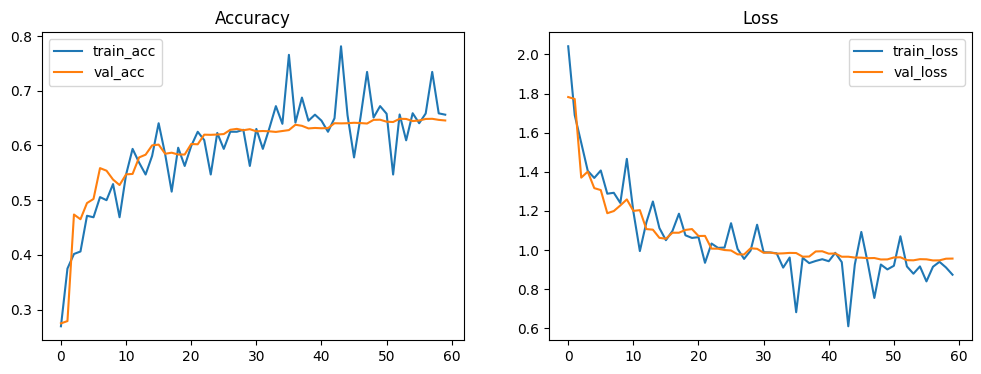

In [14]:
# Evaluate on test set

# Load best model
from tensorflow.keras.models import load_model
best_model = load_model('best_fer_model.h5')

test_loss, test_acc = best_model.evaluate(X_test, y_test_cat, verbose=2)
print(f'Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}')

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()

✅ Model loaded successfully!


Saving Training_156494.jpg to Training_156494.jpg


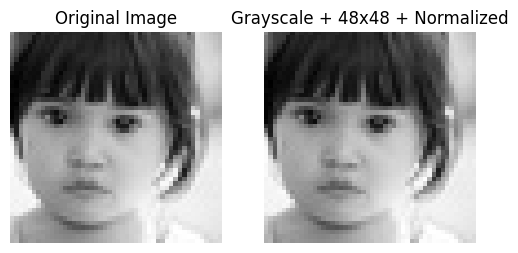

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
🧠 Predicted Emotion: Neutral (74.49% confidence)


In [21]:
# ============================================
# Test a custom image with the trained model
# ============================================

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load best model (make sure it's already trained and saved)
model_path = 'best_fer_model.h5'  # or 'fer_cnn_intensity_normalized.h5'
model = load_model(model_path)
print("✅ Model loaded successfully!")

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Read the uploaded image
    img_path = fn
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (48, 48))

    # INTENSITY NORMALIZATION to [0,1]
    img_normalized = img_resized.astype('float32') / 255.0

    # Display original + processed image
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Grayscale + 48x48 + Normalized")
    plt.axis('off')
    plt.show()

    # Reshape for model: (1, 48, 48, 1)
    img_input = np.expand_dims(img_normalized, axis=(0, -1))

    # Predict
    predictions = model.predict(img_input)
    pred_label = np.argmax(predictions)
    confidence = np.max(predictions)

    emotion_dict = {
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Sad",
        5: "Surprise",
        6: "Neutral"
    }

    print(f"🧠 Predicted Emotion: {emotion_dict[pred_label]} ({confidence*100:.2f}% confidence)")
